In [1]:
import os
import requests
import numpy as np
import pandas as pd
import vextract.svg
import vextract.filter
import vextract.convert
import vextract.unwrap
import svgpathtools as spt
import matplotlib.pyplot as plt

from pathlib import Path

%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
# Import data extracted from Dias' dissertation.

GeSe4_dict = {}

GeSe4_dict['13.5'] = pd.read_csv(
    '../data/extracted_data/GeSe4-FigB4/13p5_GPa.csv',
    names=('Temp', 'R'),
    skiprows=[0]
)

GeSe4_dict['16'] = pd.read_csv(
    '../data/extracted_data/GeSe4-FigB4/16_GPa.csv',
    names=('Temp', 'R'),
    skiprows=[0]
)

GeSe4_dict['24'] = pd.read_csv(
    '../data/extracted_data/GeSe4-FigB4/24_GPa.csv',
    names=('Temp', 'R'),
    skiprows=[0]
)

In [3]:
# The old version of the resistance plot.
# Not included in the repository for possible copyright reasons.
paper_file = '../data/source_data/Fig2_transport.pdf'

# Location to store the svg version of the relevant page.
svg_page_file = '../data/svg_files/Fig2_transport.svg'

# The page number on which the relavant figure is located.
page_number = 1

# Convert the pdf into an svg file.
os.system(f'pdf2svg {paper_file} {svg_page_file} {page_number}')

# Load the svg file into memory.
# The resulting structure is a tuple of two lists.
# The first is a list of the path objects.
# The second is a list of the corresponding attributes.
svg = (
    # Convert color codes to hex for convenience.
    vextract.convert.hexify(
        # Apply transformation matrix that is inluded in svg attributes.
        vextract.convert.apply_tmatrix(
            # load the file in a tuple of paths and attributes.
            spt.svg2paths(svg_page_file))))

# Separate paths and attributes for convenience.
paths, attributes = svg

In [4]:
# #008000 is the green color that corresponds to the 13 GPa data
vextract.svg.count_stroke_colors(svg)

#000000    359
#ff0000     23
#b56eff     21
#525252      7
#ffffff      6
#0000ff      6
#008000      5
Name: colors, dtype: int64

In [5]:
# For now focus on the 13 GPa data which is green.
green_paths = []
for path, attribute in zip(paths, attributes):
    try:
        style_dict = vextract.svg.style_string_to_dict(attribute['style'])
        if style_dict['stroke'] == '#008000':
            green_paths.append(path)
    except:
        pass
    
# The green data 13 GPa is broken up into 5 different paths for some reason.
# Here we append them and convert to x, y values.
green_xs = []
green_ys = []
for path in green_paths:
    xs, ys = vextract.svg.path_starts(path)
    green_xs = green_xs + xs
    green_ys = green_ys + ys
    
# Make a dataframe for convenience
df = pd.DataFrame()
df['x'] = green_xs
df['y'] = green_ys

Text(0.5, 1.0, '13 GPa MnS$_2$ data extracted from old version Fig2_transport.pdf')

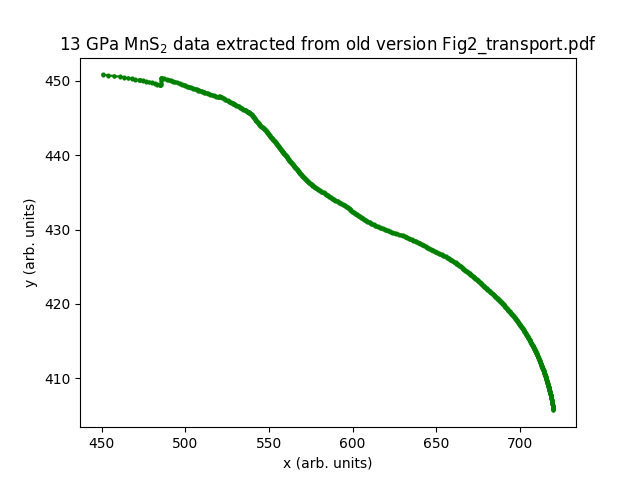

In [6]:
fig, ax = plt.subplots()
ax.plot(df.x, df.y, '-o', markersize=2, color='#008000')
ax.set_xlabel('x (arb. units)')
ax.set_ylabel('y (arb. units)')
ax.set_title('13 GPa MnS$_2$ data extracted from old version Fig2_transport.pdf')

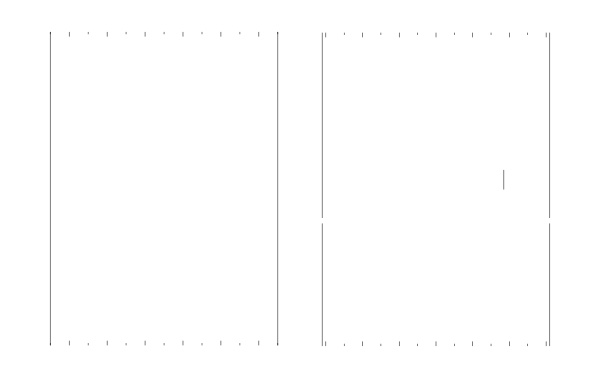

In [7]:
# Tic marks appear to be stored as horizontal and vertical lines.
# When using dark mode themem, it may be difficult to see the lines.
vextract.svg.display_svg(vextract.filter.by_vlines(svg))

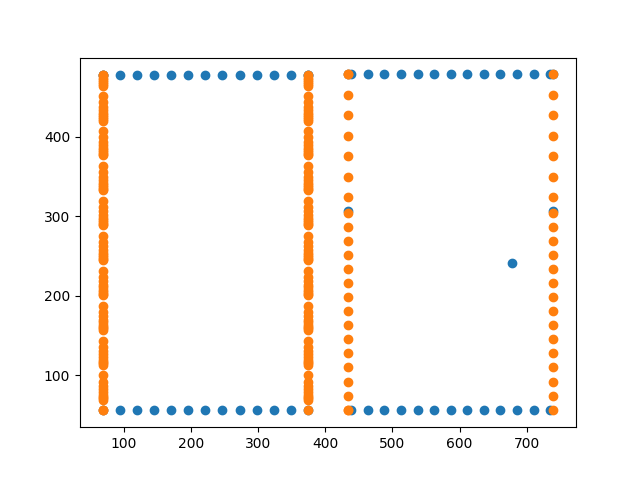

In [8]:
# Plot data to help figure out tic marks.
# Note that the image is flipped vertically.
vpaths, _ = vextract.filter.by_vlines(svg)
hpaths, _ = vextract.filter.by_hlines(svg)
df_v = pd.DataFrame()
xs, ys = zip(*[vextract.svg.path_starts(path) for path in vpaths])
df_v['x'] = [x[0] for x in xs]
df_v['y'] = [y[0] for y in ys]

df_h = pd.DataFrame()
xs, ys = zip(*[vextract.svg.path_starts(path) for path in hpaths])
df_h['x'] = [x[0] for x in xs]
df_h['y'] = [y[0] for y in ys]

fig, ax = plt.subplots()
ax.scatter(df_v.x, df_v.y)
ax.scatter(df_h.x, df_h.y)

In [9]:
# These are the x locations (in svg units) of the lower x axis
# for Figure 1b
x_min = df_v[df_v.y < 100][df_v.x > 435].x.min()
x_max = df_v[df_v.y < 100][df_v.x > 435].x.max()

# Read from scale of plot.
T_min = 0
T_max = 300

print(f'{x_min = }, {x_max = }')

x_min = 438.6836197390916, x_max = 734.9766777507332


/tmp/ipykernel_345814/815395871.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_min = df_v[df_v.y < 100][df_v.x > 435].x.min()
/tmp/ipykernel_345814/815395871.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_max = df_v[df_v.y < 100][df_v.x > 435].x.max()


In [10]:
# Same thing for the x-axis
y_min = df_h[df_h.x > 400][df_h.y > 313].y.min()
y_max = df_h[df_h.x > 400][df_h.y > 313].y.max()

R_min = 1.5
R_max = 4.5

print(f'{y_min = }, {y_max = }')

y_min = 323.7420925559625, y_max = 478.41001742707886


/tmp/ipykernel_345814/354212754.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_min = df_h[df_h.x > 400][df_h.y > 313].y.min()
/tmp/ipykernel_345814/354212754.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_max = df_h[df_h.x > 400][df_h.y > 313].y.max()


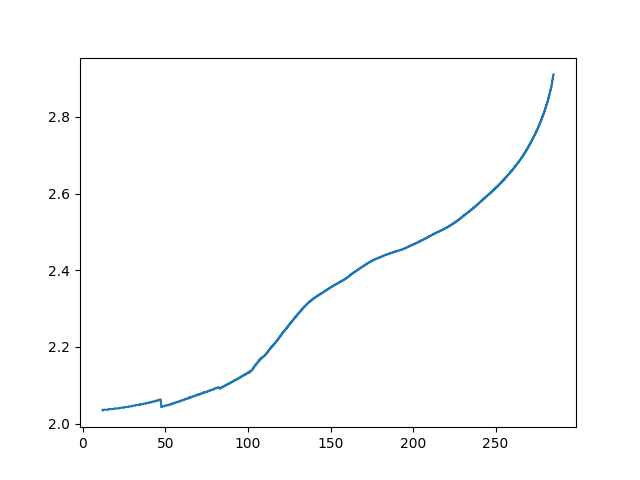

In [11]:
# Now we have the scale factors for both the x and y axes, so we can
# add columns to our data sets to represent properly scaled data.
# While we are at it, plot the data so we can see how it looks.

fig, ax = plt.subplots()
df['R'] = df.y.apply(lambda R_arb: vextract.svg.transform_coord(y_min, y_max, R_max, R_min, R_arb))
df['Temp'] = df.x.apply(lambda Temp_arb: vextract.svg.transform_coord(x_min, x_max, T_min, T_max, Temp_arb))    

ax.plot(df.Temp, df.R)

In [12]:
# Export the data to csv files.

# We only want the Temp and R columns, not x and y
df_csv = df[['Temp', 'R']].copy()
# rename the columns for better labeling in the csv
df_csv.columns = ['Temperature(K)', 'Resistance(Ohms)']
df_csv.to_csv(
    f'../data/extracted_data/MnS2/13_GPa_higher_res.csv',
    index=False
)

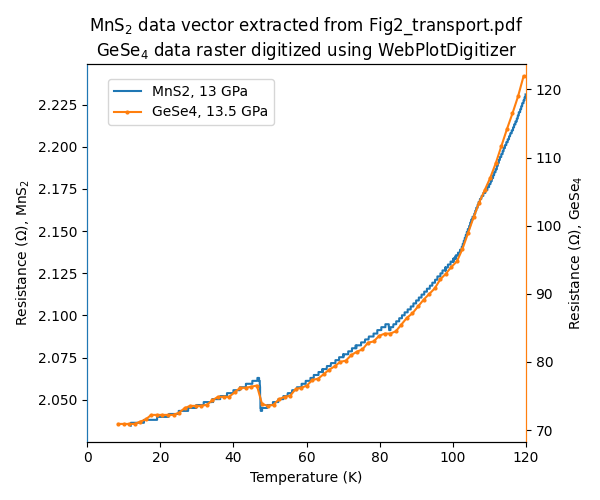

In [13]:
# This data was digitized using webplotdigitizer.
# More points were sampled than in my initial analysis.
df2 = pd.read_csv(
    '../data/extracted_data/GeSe4-FigB4/13p5_GPa_higher_res.csv',
    names=['Temp', 'R']
)

fig, ax = plt.subplots(figsize=(6, 5))

tmax = 120

mask = df.Temp < tmax
ax.plot(df.Temp[mask], df.R[mask], label='MnS2, 13 GPa')

ax2 = ax.twinx()

mask = df2.Temp < tmax
ax2.plot(df2.Temp[mask], df2.R[mask], '-o', markersize=2, label='GeSe4, 13.5 GPa', color='tab:orange')

# These ylim values were copied from the original version
# of the plot (see notebook 05_MnS2.ipynb).
# We use the same one's here to ease comparison.
ax.set_ylim(2.0251317878631854, 2.2489886152261844)
ax2.set_ylim(68.29096268384589, 123.71280539686408)
ax.set_xlim(0, 120)

ax.spines['left'].set_color('tab:blue')
ax.spines['right'].set_color('tab:orange')
ax2.spines['left'].set_color('tab:blue')
ax2.spines['right'].set_color('tab:orange')

ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Resistance ($\Omega$), MnS$_2$')
ax2.set_ylabel('Resistance ($\Omega$), GeSe$_4$')
ax.set_title(
    'MnS$_2$ data vector extracted from Fig2_transport.pdf\nGeSe$_4$ data raster digitized using WebPlotDigitizer'
)

fig.legend(loc=(0.18, 0.75))

fig.tight_layout()

plt.savefig('../MnS2_figures/13GPa_higher_resolution.pdf')